# Overlaying plots

## Preliminaries

In [1]:
library(brms)
library(tidyverse)

#-------------------------------------------------------------------------------
#--- Useful functions
#-- find the root
#-------------------------------------------------------------------------------
GamF <- function(gam, p0) {
    (2 * pnorm(-abs(gam)) * exp(.5 * gam^2) - p0)^2
}

# optimize(GamF,interval = c(-30,30), p0=1 - 0.05)
GamBnd <- function(p0) {
    Re1 <- optimize(GamF, interval = c(-30, 30), p0 = 1 - p0)
    Re2 <- optimize(GamF, interval = c(-30, 30), p0 = p0)

    c(-abs(Re1$minimum), abs(Re2$minimum), Re1$objective, Re2$objective)
}
GamBnd <- Vectorize(GamBnd, "p0")

#-------------------------------------------------------------------------------
#--- Function
#-------------------------------------------------------------------------------
#--- Stan function (case 2)
tau0 <- .1


Bd <- GamBnd(tau0)[1:2]
# GAL2 <- custom_family(
#  "GAL2", dpars = c("mu", "sigma","ligam", "tau","gamL","gamU"), links=c("identity","log","identity","identity", rep("identity",2)),
#  lb=c(NA,0, -1.087,0,NA,NA), ub=c(NA,NA, 1.087,1,NA,NA), type="real") #, vars = "vint1[n]"
# GAL2 <- custom_family(
#   "GAL2", dpars = c("mu", "sigma","ligam"), links= c("identity","log","identity"),
#   lb=c(NA,0, -1.087), ub=c(NA,NA, 1.087), type="real", vars = c("tau","gamL","gamU")) #, vars = "vint1[n]"
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, -1.086, 0), ub = c(NA, NA, 1.086, 1), type = "real"
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "logit", "identity"),
    lb = c(NA, 0, -15, 0), ub = c(NA, NA, 15, 1), type = "real", vars = c("gamL", "gamU")
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau", "gamL", "gamU"), links = c("identity", "log", "identity", "identity", rep("identity", 2)),
    lb = c(NA, 0, -15, 0, NA, NA), ub = c(NA, NA, 15, 1, NA, NA), type = "real"
) # , vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .99, 0), ub = c(NA, NA, Bd[2] * .99, 1), type = "real"
) # , vars = "vint1[n]"


stan_funs2 <- "
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  "


#--- Now define all of these here
# stanvars <- stanvar(scode = stan_funs, block = "functions")
stanvars2 <- stanvar(scode = stan_funs2, block = "functions")

# priorval = c(prior(normal(0, 15), class = "Intercept"),
#           # Prior guess of 80% of the terms are non-zero
#           prior(horseshoe(par_ratio =0.8), class = "b"))

#--- Fit the quantile regression
#-- quantile

# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace(), prior = set_prior(horseshoe(df=1,par_ratio = 0.1), class="b"))
# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace())

# fit_fakeqGal.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL,
#                             stanvars = stanvars,chains = 3,iter = 10000, control = list(adapt_delta = 0.97, max_treedepth = 10))


# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 3,iter = 1000)
# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5,gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 2000, init = 0.1, control = list(adapt_delta = 0.97))

# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.9 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.1 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,


Loading required package: Rcpp

Loading 'brms' package (version 2.18.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


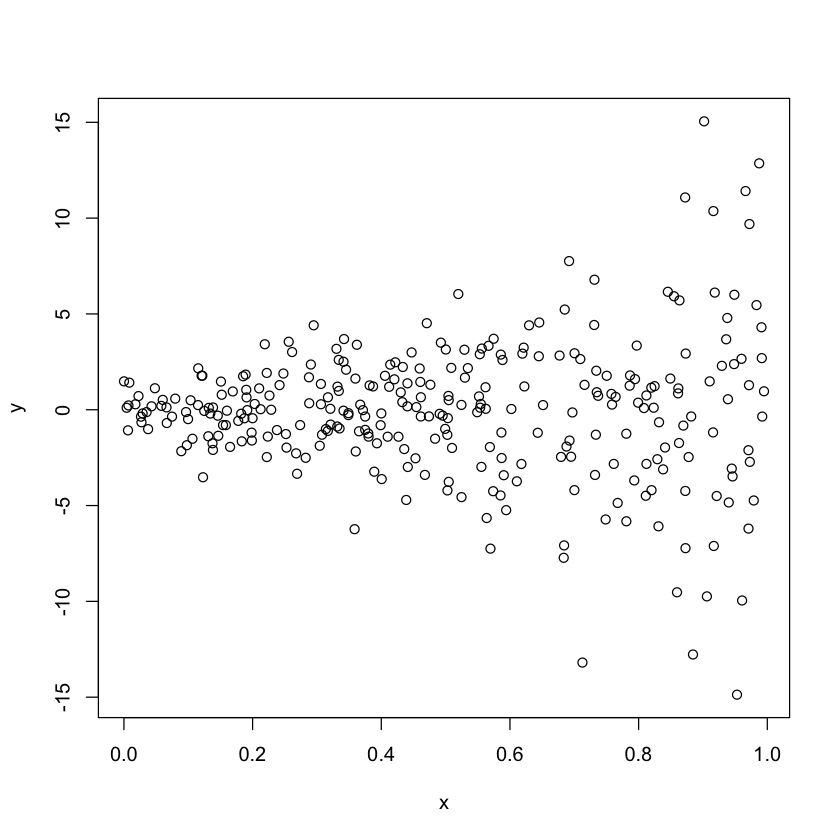

In [2]:
N <- 300
x <- runif(N, 0, 1)
y <- rnorm(N, mean = 0, sd = exp(2*x))

synthetic <- data.frame(x = x, y = y)
plot(x, y)

## Overlaying plot

In [8]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ s(x), sigma ~ x, tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [9]:
summary(q25)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         sigma ~ x
         tau = 0.25
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)     1.30      1.08     0.06     4.11 1.00      856      969

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -1.81      0.22    -2.24    -1.39 1.00     1859     1394
sigma_Intercept    -1.17      0.14    -1.44    -0.89 1.00     1700     1437
sigma_x             1.92      0.18     1.57     2.29 1.00     3035     1427
sx_1               -6.02      3.73   -13.78     1.11 1.00     1058      916

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam     1.34      0.16     1.03     1

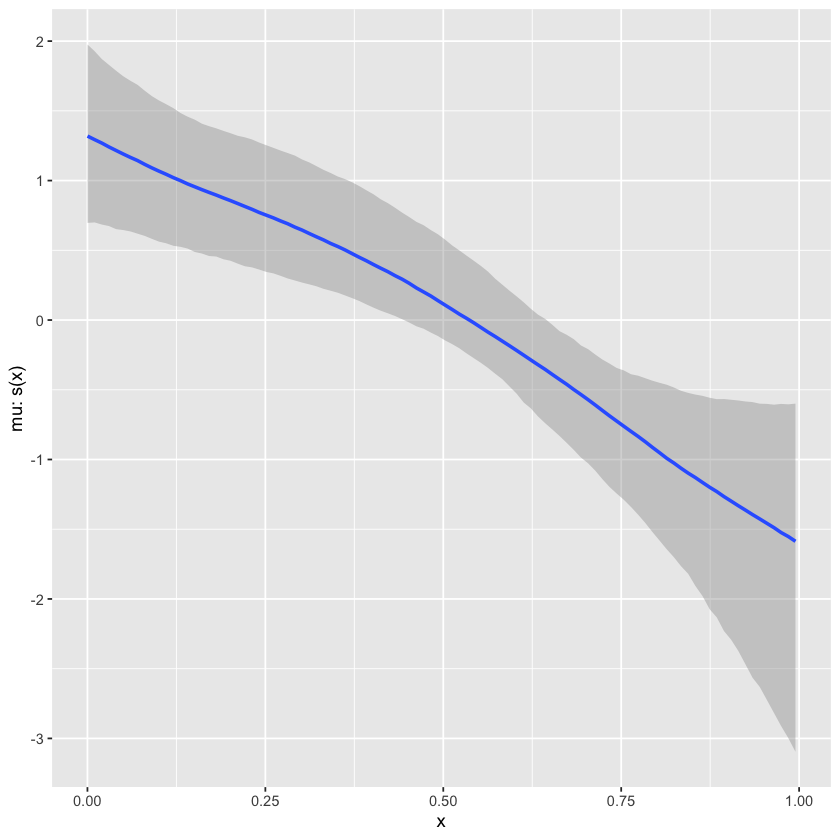

In [10]:
csq25 <- conditional_smooths(q25)
plot(csq25)

In [11]:
(csq25df <- csq25[[1]])

x,effect1__,cond__,estimate__,se__,lower__,upper__
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0.0001056115,0.0001056115,1,1.3190288,0.3284109,0.6966900,1.975731
0.0101538157,0.0101538157,1,1.2934332,0.3183309,0.6999275,1.927206
0.0202020198,0.0202020198,1,1.2689859,0.3074003,0.6847174,1.871576
0.0302502240,0.0302502240,1,1.2411506,0.3021550,0.6738922,1.829329
0.0402984282,0.0402984282,1,1.2156914,0.2943745,0.6518284,1.787416
0.0503466323,0.0503466323,1,1.1903574,0.2880862,0.6451066,1.747879
0.0603948365,0.0603948365,1,1.1661326,0.2827698,0.6353715,1.715613
0.0704430406,0.0704430406,1,1.1434206,0.2785981,0.6192645,1.686491
0.0804912448,0.0804912448,1,1.1162423,0.2724763,0.6032464,1.644371


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


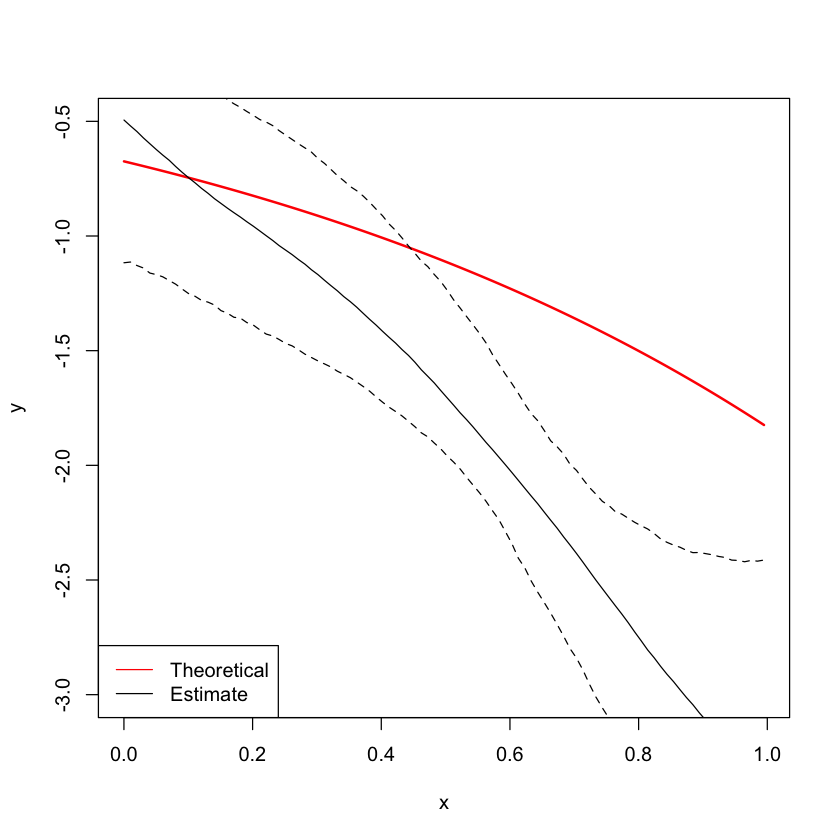

In [12]:
b <- summary(q25)$fixed[1,1]
plot(csq25df$x, qnorm(.25)*exp(csq25df$x), type = "l", lwd = 2, col = "red", xlab = "x", ylab = "y", ylim = c(-3, -0.5))
lines(csq25df$x, b + csq25df$estimate__)
lines(csq25df$x, b + csq25df$lower__, lty = 2)
lines(csq25df$x, b + csq25df$upper__, lty = 2)
legend("bottomleft", legend = c("Theoretical", "Estimate"), lty = 1, col = c("red", "black"))

## Trying sigma ~ s(x)

In [14]:
q25s <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .25), data = synthetic, 
family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, 
control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling



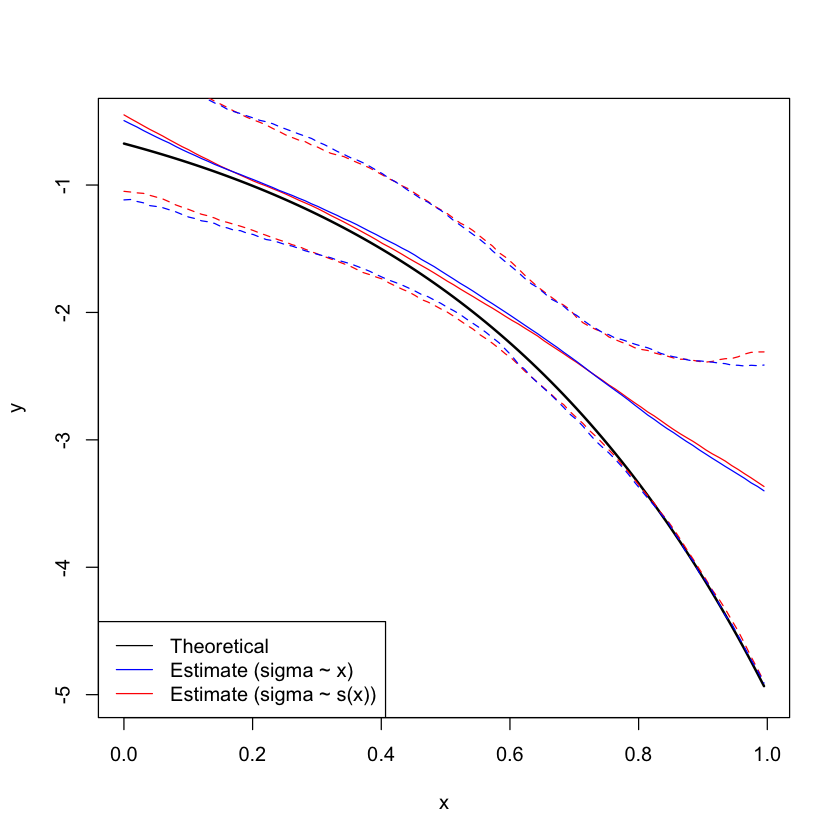

In [22]:
csq25s <- conditional_smooths(q25s)
csq25sy <- csq25s[[1]]
csq25ssigma <- csq25s[[2]]

a_y <- summary(q25s)$fixed[1,1]
a_sigma <- summary(q25s)$fixed[2,1]

plot(csq25sy$x, qnorm(.25)*exp(2*csq25sy$x), type = "l", lwd = 2, xlab = "x", ylab = "y", ylim = c(-5, -0.5))
lines(csq25sy$x, a_y + csq25sy$estimate__, col = "red")
lines(csq25sy$x, a_y + csq25sy$lower__, lty = 2, col = "red")
lines(csq25sy$x, a_y + csq25sy$upper__, lty = 2, col = "red")
lines(csq25df$x, b + csq25df$estimate__, col = "blue")
lines(csq25df$x, b + csq25df$lower__, lty = 2, col = "blue")
lines(csq25df$x, b + csq25df$upper__, lty = 2, col = "blue")
legend("bottomleft", legend = c("Theoretical", "Estimate (sigma ~ x)", 
"Estimate (sigma ~ s(x))"), lty = 1, col = c("black", "blue", "red"))


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


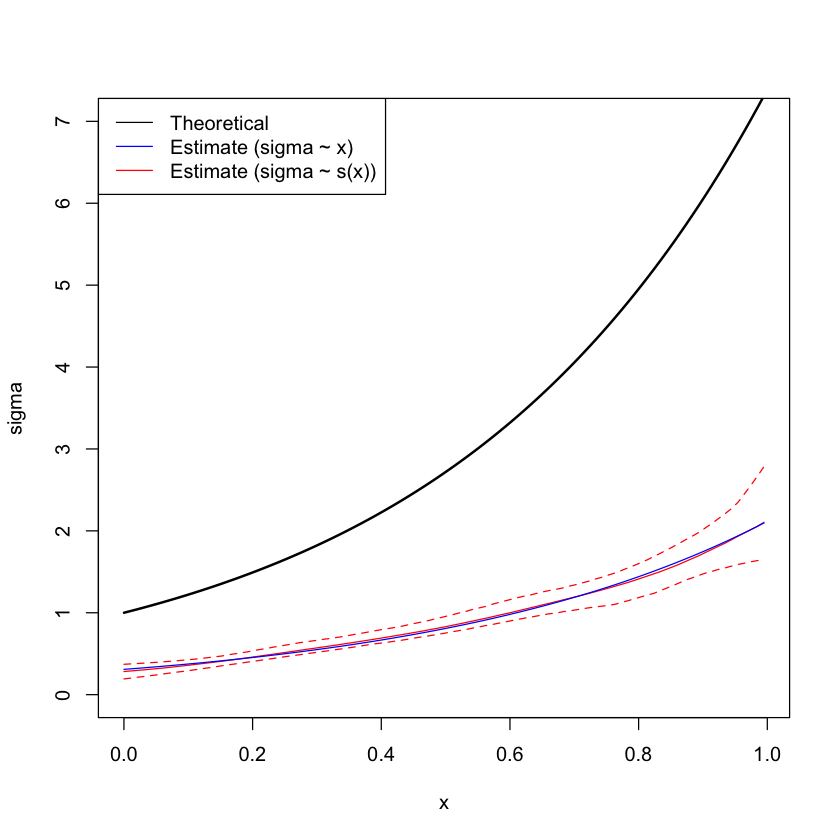

In [31]:
c <- summary(q25)$fixed[2,1]
d <- summary(q25)$fixed[3,1]

plot(csq25ssigma$x, exp(2*csq25ssigma$x), type = "l", lwd = 2, xlab = "x", ylab = "sigma", ylim = c(0, 7))
lines(csq25ssigma$x, exp(a_sigma + csq25ssigma$estimate__), col = "red")
lines(csq25ssigma$x, exp(a_sigma + csq25ssigma$lower__), lty = 2, col = "red")
lines(csq25ssigma$x, exp(a_sigma + csq25ssigma$upper__), lty = 2, col = "red")
lines(csq25df$x, exp(c)*exp(d*csq25df$x), col = "blue")
legend("topleft", legend = c("Theoretical", "Estimate (sigma ~ x)",
"Estimate (sigma ~ s(x))"), lty = 1, col = c("black", "blue", "red"))

In [13]:
save(file = "log_sigma.RData", list = ls())